# SI on a slope

This notebook takes a single output of the 2D_SI_DNS dedalus run. Makes descriptive plots and analyzes energetics.

Author: Jacob Wenegrat

In [409]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Load variables

In [410]:
#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5' #Ruan case F
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F

#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A
#filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'
#filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1.h5'

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w'] # Slope-normal direction
b = f['tasks']['b'] # Perturbation buoyancy

qa = f['tasks']['PVa']
q = f['tasks']['PV']
wq = f['tasks']['wq']
# Energy terms XXX - Need to go clean these up in Dedalus
gsp = f['tasks']['GSP']
gspr = f['tasks']['GSProtated']
vspu = f['tasks']['VSPu']
vspv = f['tasks']['VSPv']
vsp = vspu[:,:,:]+vspv[:,:,:]
lspu = f['tasks']['LSPu']
lspv = f['tasks']['LSPv']
lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
vbf = f['tasks']['VBF']
# vbfsg= f['tasks']['VBFsg']
vbfr = f['tasks']['VBFr']
hbfr = f['tasks']['HBFrotated']
hbfr = hbfr*np.sin(tht[0,0,0])
vbfrot = f['tasks']['VBFrotated']
sp = f['tasks']['SP']
EKE = f['tasks']['EKE']

# SPECTRAL QUANTITIES
ws = f['tasks']['wcs']
bs = f['tasks']['bs']
vs = f['tasks']['vcs']


# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

In [411]:
# Calculated quantities
# XXX- Go through and check this all carefully
va = np.mean(v, axis=1)

qm = np.mean(q, axis=1) 
bm = np.mean(b, axis=1)
bxc = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :,np.newaxis], axis=1)*np.cos(tht)- np.gradient(b, axis=-1)/np.gradient(z[np.newaxis, np.newaxis,:], axis=-1)*np.sin(tht) #f['tasks']['bxs']
bx = np.gradient(b, axis=1)/np.gradient(x[np.newaxis, :, np.newaxis], axis=1)
bxcm = np.mean(bxc, axis=1)
bxm = np.mean(bx, axis=1)

bzr = np.gradient(bm, axis=-1)/np.gradient(z)*np.cos(tht[0,0,0]) + bxcm*np.sin(tht[0,0,0]) + N**2

um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
up = u - um[:,np.newaxis,:]
vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(np.mean(w, axis=1), axis=-1)/np.gradient(z)
zm = z-z[-1]
qt = np.transpose(np.transpose(np.gradient(qm, axis=0))/np.gradient(time))
qta = np.gradient(qa[:,0,0])/np.gradient(time)
bb = x[np.newaxis,:,np.newaxis]*N**2*np.sin(tht[0,0,0]) + N**2*np.cos(tht[0,0,0])*z[np.newaxis, np.newaxis,:]
bf = b + bb
bz = np.gradient(bm, axis=-1)/np.gradient(z) + N**2
bz_prime = np.gradient(bm, axis=-1)/np.gradient(z)
Ri = bz/(uz**2 + vz**2)

gsps = 2*np.real(-np.conj(vs)*ws*bxcm[:,np.newaxis,:]/1e-4)
vbfs = 2*np.real(np.conj(ws)*bs)

#zetaprimebprime = np.mean((bf - np.mean(bf,axis=1))*(np.gradient(v, axis=1)/np.gradient(x)), axis=1)
uz = np.gradient(u, axis=-1)/np.gradient(z)
vz = np.gradient(v, axis=-1)/np.gradient(z)
EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKE = 0.5*(um**2 + (vm)**2)
MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# SPECTRAL
wbs = 2*np.real(np.conj(ws)*bs)
wvs = 2*np.real(np.conj(ws)*vs)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [412]:
MKE = np.mean(0.5*(u[:,:,:]**2 + (v[:,:,:])**2 + w[:,:,:]**2), axis=1)
# MKE = 0.5*(um**2 + (vm)**2)

MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

# MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
# MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKEMPE = um[:,:]*bm[:,:]*np.sin(tht[0,0,0])

## Estimate bottom stress and Ekman transport

The bottom stress is needed to calculate the cross-slope Ekman transport. 
There are several ways to calculate this. The first is directly, given that we resolve the viscous layer ($\delta_v = \nu/u^*$).
\begin{equation}
\tau_y = \rho \nu \frac{\partial v}{\partial z}
\end{equation}
where $\nu$ is the subgrid viscosity.

The other way (which would in some sense be preferable for observational purposes, would be using a drag coefficient:
\begin{equation}
\tau_y = \rho C_d \sqrt{u^2 + v^2}v
\end{equation}
This appears to work reasonably well, however it has to be evaluated on the order of meters above the bottom. Not sure how this is supposed to actually be evaluated (ie. is there a principled way to pick the depth?).

Using these the cross-slope Ekman transport is given by,

\begin{equation}
B_{Ek} = \frac{\tau_y}{\rho_o f} N^2 \sin{\theta}
\end{equation}

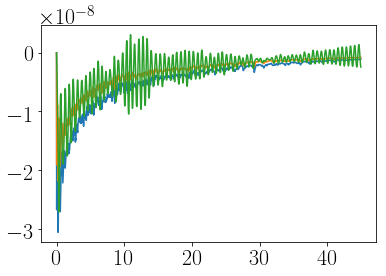

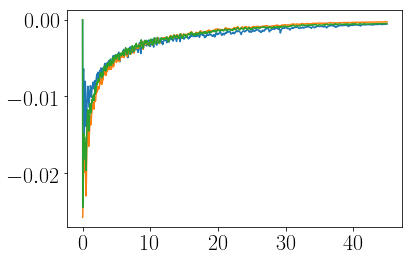

In [413]:
uss = 1e-4*np.sqrt(np.mean(uz[:,:,0], axis=1)**2 + np.mean(vz[:,:,0], axis=1)**2) # This is u*^2...need to confirm this definition
uss = 1e-4*np.sqrt(np.mean(uz[:,:,0]**2 + vz[:,:,0]**2, axis=1))
us = np.sqrt(uss)
usm = np.mean(us)
delv = 1e-4/usm

tauy = -1035*1e-4*np.mean(vz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS
taux = -1035*1e-4*np.mean(uz[:,:,0], axis=1) #Note that 1e-4 is the viscosity for the DNS

zind = 16
cd = 2.5e-3
tauya = -1035*cd*np.mean(np.sqrt(u[:,:,zind]**2 + (v[:,:,zind]+0.1)**2)*(v[:,:,zind]+0.1), axis=1)
#tauy= tauya
# This plot is to confirm that the viscous layer is being resolved
#plt.figure()
#plt.plot((z[1:]-z[:-1])/delv, 0.5*(z[1:] + z[:-1]), marker='x')

# calculate bottom velocity at 50*delv
nt = time.size
ub = np.zeros((nt,))
vb = np.zeros((nt,))
for i in range(1,nt):
    tempind = np.where(z>50*1e-4/us[i])[0][0]
    ub[i] = um[i,tempind]
    vb[i] = vm[i,tempind]+0.1
# Can calculate the Ekman transport using bottom stress:
Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])
Beka = tauy/(1030*1e-4*(1+N**2*np.sin(tht[0,0,0])**2/1e-8))*N**2*np.sin(tht[:,0,0])

# Alternately calculate the actual cross-slope buoyancy transport
Ubar = integrate.trapz(um,x=zm, axis=-1 )
BekD = Ubar*N**2*np.sin(tht[:,0,0])
#Bek = Beka
# Compare three estimates of stress
plt.plot(time/86400, Bek)
plt.plot(time/86400, Beka)
plt.plot(time/86400, BekD)

plt.figure()
plt.plot(time/86400, tauy)
plt.plot(time/86400, tauya)
plt.plot(time/86400, -1030*cd*np.sqrt(ub**2 + vb**2)*vb)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


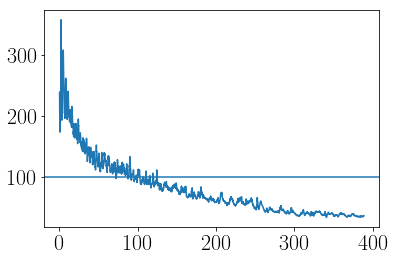

In [449]:
# Look at Slope Monin Obukhov Length as in Ruan et al. 2019

Lo = us**3/(0.4*-Beka)
zs = 1e-4/us
plt.plot(time*1e-4, Lo/zs)
plt.axhline(100) # Approximate relaminarization point

0.4001066908494838
0.7231385169123109
7.087365125516263


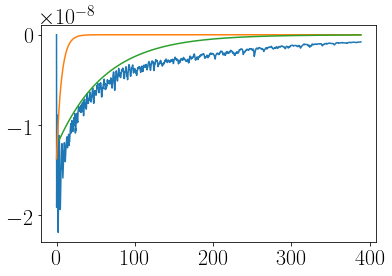

In [415]:
plt.plot(time*1e-4, Beka)
# plt.plot(time*1e-4, tauy/(1+S))

S = N**2*np.tan(tht[0,0,0])**2/1e-8
print(S)
tscale = (1/((S)**2*1e-4*np.cos(tht[0,0,0]))) #MR91
print(tscale/86400)
cd = 5e-3
d = cd*N/1e-4 #BL01
gamma =  (1 + np.sqrt(1+4*(1-S/(1+S))**(-1)*S))/2
tscaleBL = gamma*(1+S)/(2*1e-4*0.4*d*S**(3/2)) #BL01
print(tscaleBL/86400)
ind = 20
plt.plot(time*1e-4,Beka[2]*exp(-time/tscale))
plt.plot(time[ind:]*1e-4,Beka[ind]*exp(-(time[ind:]-time[ind])/tscaleBL))

/usr/local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


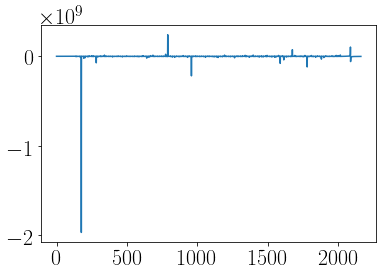

In [416]:
#calculate arrest timescale using vertically integrated cross-shelf transport
Ubars = savgol_filter(Ubar, 48*5+1, 2)
Ubart = np.gradient(Ubars)/np.gradient(time)
tauyt = np.gradient(tauy)/np.gradient(time)
t0 = 1e-4/(N**2*np.sin(tht[0,0,0]))
D = -Ubars/(Ubart)


# D = -tauy/tauyt
# D = savgol_filter(D, 48*5+1, 2)
plot(D)
# plot(Ubars)
# plt.ylim((0, 86400*10))

[-5.69491241e-03  6.39454402e-07]
[[ 7.97000000e-10 -8.92938283e-14]
 [-8.92938283e-14  1.33908261e-17]]
18.099920867650003
7.087365125516263


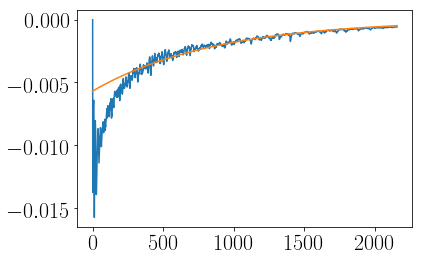

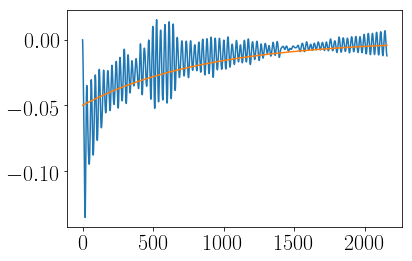

In [452]:
def fitfunc(x, a, b):
    return a * np.exp(-b * x) 

startind = 48*5
popt, pcov = curve_fit(fitfunc, time[startind:], tauy[startind:], p0=[tauy[startind], 1/tscaleBL])
print(popt)
print(pcov)
print(1/popt[1]/86400)
print(tscaleBL/86400)
plt.plot(tauy)
plt.plot(fitfunc(time, popt[0], popt[1]))

plt.figure()
plt.plot(Ubar)
plt.plot(fitfunc(time, -0.05, popt[1]))

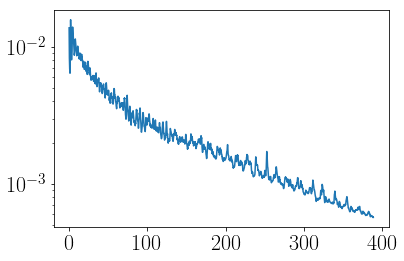

In [454]:
plt.figure()
plt.semilogy(time*1e-4, -tauy)

In [419]:
S = N**2*np.tan(tht[0,0,0])**2/1e-8
tscale = (1/((S)**2*1e-4*np.cos(tht[0,0,0])))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(-199.99623505652022, -194.99623505652022)

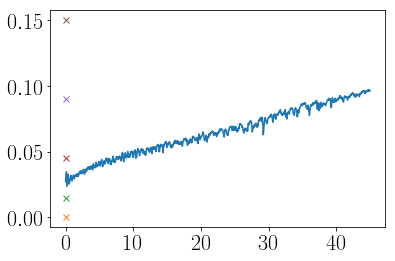

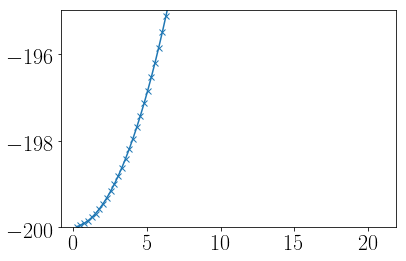

In [420]:
# Plot resolution inside the viscous layer (note Ruan et al. 2019 uses 2 points in 5*deltav)
plt.figure()
plt.plot(time/86400, 1e-4/us)
plt.plot(0, np.transpose(zm[0:5,np.newaxis] - zm[0]), marker='x');

# Plot delta z normalized by viscous units
deltaz = zm[1:] - zm[:-1]
plt.figure()
plt.plot(deltaz/delv, zm[1:], marker='x')
plt.ylim((zm[0], zm[0]+5))

## Calculate the 0 PV layer depth (H)

This code calculates the depth of the zero PV layer using:
\begin{equation}
\frac{\partial H^2}{\partial t} = 2 \frac{B_{Ek}(t)}{N^2}
\end{equation}

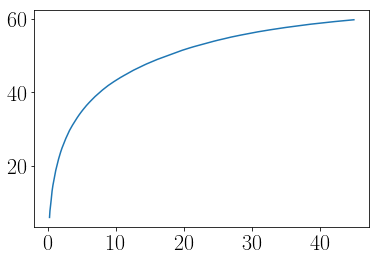

In [421]:
nt = BekD.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

toff = 12
Ho = 5
Ent = 1.0 # Entrainment factor...
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*Ent*-Bek[i]/(N**2))*(time[i]-time[i-1])
    
H = np.sqrt(Ho**2 + H2)
H[0:toff] = np.nan
plt.plot(time/86400, H)

## Calculate the convective layer depth

Note, to do this I need to complete the derivation, and then fit a coefficient to the model runs. Alternately, could directly infer this as the point at which $\langle w' b' \rangle = 0$.

If I assume $v' \sim h/H V^{int}$, then the equation to solve is,

\begin{equation}
 \left(\frac{h}{H} \right)^4 + c^3\frac{B_{Ek}^2}{V^3H}\left(\frac{f}{N^2 \theta}\right)^3\left(1 - \frac{h}{H}\right)^3
\end{equation}

In [422]:
def fitn(ent, Htotal):
    def fitHN(factor, C):
        nt = factor.size
        h = np.ones((nt))
        entm = np.mean(ent)
        for i in range(0, nt):
            poly = np.zeros((5,))
            poly[0] = 1
            poly[1] = -C**3*factor[i]*ent[i]**3
            poly[2] = C**3*3*factor[i]*ent[i]**2
            poly[3] = -C**3*3*factor[i]*ent[i]
            poly[4] = C**3*factor[i]
            
            def f(x):
                #return poly[0]*x**4 + poly[1]*x**3 + poly[2]*x**2 + poly[3]*x + poly[4]
                return x**4 - C**3*factor[i]*(1-ent[i]*x)**3
                #return x - C**3*factor[i]*(1-ent[i]*x)**3
            
            if np.isfinite(factor[i]):
                roots = np.roots(poly)
                sol = optimize.root(f, [0, 1], method='lm',options= {'maxfev':10000, 'maxiter':1000, 'ftol':0.001})
#                 print(sol)
                if not sol.success:
                    print('fail')
    #                     h[i] = np.nan
                    print(sol)
                    ind = np.where(imag(roots)==0)
                    if size(ind)>0:
                        roots = real(roots[ind])
                        roots = np.sort(roots)
                        h[i] = roots[0]
                #print('here' + str(sol.x))
                else:
                    h[i] = (np.sort(sol.x)[0])
#                     h[i] = sol.x
                #h[i] = real(roots[-1])
                #print(roots)

        #h[h<0] = np.nan
        return h*Htotal
    return fitHN
h = fitn(1+0*Bek, H)(Bek**2/(H*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3, 189)
# h = fitH(Bek**2/(H*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3, 15)*H

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: OptimizeWarning: Unknown solver options: maxfev


In [423]:
# mean coefficient
coef = Bek**2/(H*0.1**3)*(1e-4/(N**2*np.tan(tht[0,0,0])))**3*189**3
print(coef[-1])

0.017308192494327353


In [424]:
us[-1]**3/(0.4*0.1)**3

1.7406028595777824e-05

In [425]:
us[-1]**3/(H[-1]*Bek[-1])

-0.016826722581116248

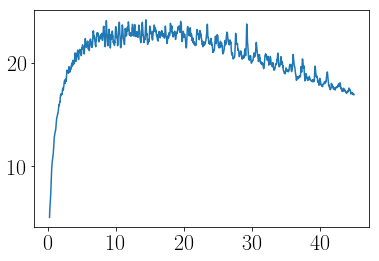

In [426]:
plt.plot(time/86400, h)

## Trajectory in S, Ri space

Calculate the Richardson number and Slope Burger number averaged over the zero PV layer to look at the trajectory in S-Ri space (per Wenegrat et al. 2018).

In [427]:
#%% Trajectory in S, Ri space

Ri = np.zeros((nt,))
RiB = np.zeros((nt,))
S = np.zeros((nt,))
alpha = np.zeros((nt,))
Sr = np.zeros((nt,))
testr = np.zeros((nt,))
deltabottom = 10

for i in range(0, nt):
    if not (np.isnan(H[i]) or H[i]<2*deltabottom):
        zl = np.where((zm>zm[0]+deltabottom) & (zm<zm[0]+H[i]))[0]
    else: 
        zl = np.where((zm>zm[0]+deltabottom) & (zm<zm[0]+2*deltabottom))[0]
    zd = zm[zl[-1]] - zm[zl[0]]
    uzm = np.mean(uz, axis=1)
    vzm = np.mean(vz, axis=1)
    #wzm = np.mean(wz, axis=1)
    uzm = np.trapz(uzm[i,zl]*np.cos(tht[0,0,0]), x=zm[zl], axis=-1)/zd
    vzm = np.trapz(vzm[i,zl]*np.cos(tht[0,0,0]), x=zm[zl], axis=-1)/zd
    wzm = np.trapz(wz[i,zl]*np.cos(tht[0,0,0]), x=zm[zl], axis=-1)/zd
    sh2  = uzm**2 + vzm**2 + wzm**2
    bzm = np.trapz(bzr[i,zl], x=zm[zl], axis=-1)/zd
    Ri[i] = bzm/sh2
    RiB[i] = bzm*1e-8/(((np.trapz(bz_prime[i,zl], x=zm[zl], axis=-1)/zd)*np.sin(tht[0,0,0]))**2)
    testr[i] = (np.trapz(bz_prime[i,zl], x=zm[zl], axis=-1)/zd)*np.sin(tht[0,0,0])/1e-8
    S[i] = bzm/1e-8*np.tan(tht[0,0,0])**2
    Sr[i] = np.trapz(bz_prime[i,zl], x=zm[zl], axis=-1)/zd/1e-8*np.tanh(tht[0,0,0])**2
    alpha[i] = np.sqrt(S[i]*Ri[i])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


In [428]:
S.shape

(2160,)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


(0, 5)

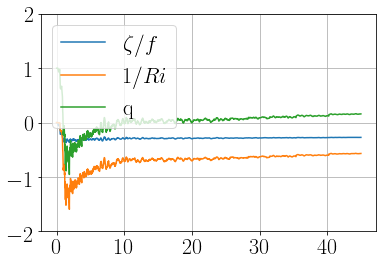

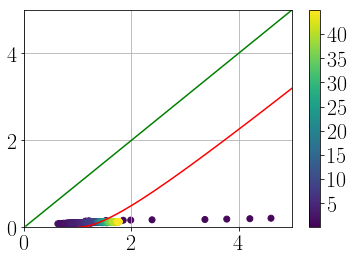

In [429]:
plt.figure()
plt.plot(time/86400, -alpha/Ri, label='$\zeta/f$')
plt.plot(time/86400, -1/Ri, label='$1/Ri$')

plt.plot(time/86400, 1-alpha/Ri-1/Ri, label='q')
plt.legend()
plt.grid()

plt.ylim((-2, 2))
plt.figure()
#plt.plot(Ri, S, linestyle='none', marker='x')
plt.scatter(Ri, S, c=time/86400)
plt.colorbar()
Ria = np.linspace(0, 20, 1000)
Sa = np.linspace(0, 10, 1000)
Rv, Sv = np.meshgrid(Ria, Sa)
plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv + 1/Rv, [0, 1], colors='r')
plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv, [0, 1], colors='g')
plt.grid()
#plt.colorbar()
plt.xlim((0, 5))
plt.ylim((0, 5))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


(0, 3)

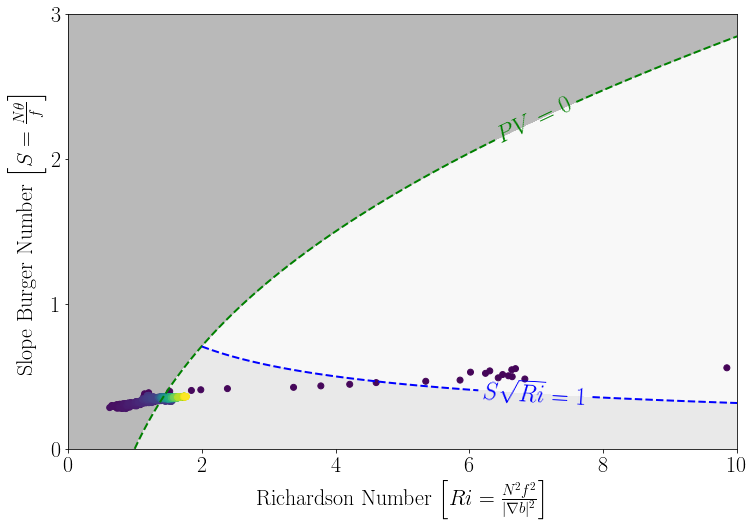

In [430]:
Rit = np.linspace(0, 10, 1000)
St = np.linspace(0, 3, 1000)
Rv, Sv = np.meshgrid(Rit, St)
alpha = Sv*np.sqrt(Rv)
plt.figure(figsize=(12,8))
PV = Sv*np.sqrt(Rv)/Rv + 1/Rv
maskSI = PV>1
maskBI = np.nan*np.zeros_like(Rv)
maskBI[np.logical_and(PV<=1, alpha<1)] = 1
# maskBI[np.logical_and(PV<=1, 1==1)] = 1

maskBIL = np.nan*np.zeros_like(Rv)
maskBIL[PV<=1] = 1
# maskBI = PV<=1
# maskBI[np.logical_not(maskBI)] = np.nan
cl = 8
plt.contourf(Rv, Sv, maskSI*3, np.linspace(0, cl, 10), cmap='Greys')
plt.contourf(Rv, Sv, maskBI*1, np.linspace(0, cl, 10), cmap='Greys')

# plt.contour(Rv, Sv, (1-Sv**2/(1+Sv**2))*Rv, [0, 1], colors='r')
# plt.contour(Rv, Sv, (Sv/(1+Sv)) + 1/Rv, [1], colors='r')
PVL = plt.contour(Rv, Sv, -1 + Sv*np.sqrt(Rv)/Rv + 1/Rv, [0], colors='g', linewidths=2, linestyles='dashed')
# plt.contour(Rv, Sv, alpha/Rv, [0.2], colors='b', linewidths=2, linestyles='dashed')
CL = plt.contour(Rv, Sv, alpha*maskBIL, [1], colors='b', linewidths=2, linestyles='dashed')
plt.clabel(CL, inline=1, fontsize = 24, fmt='$S\sqrt{Ri}$ $=$ %1.0f', manual=[(7, 0.5)])
plt.clabel(PVL, inline=1, fontsize = 24, fmt='$PV$ $=$ %1.0f', manual = [(7, 2.25)])
plt.yticks([0, 1, 2, 3])

plt.scatter(Ri, np.sqrt(S), c=time/86400)

# plt.contour(Rv, Sv, Sv*np.sqrt(Rv) + 1/Rv, [1], colors='g')

# plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv, [0, 1], colors='g')
# plt.contour(Rv, Sv, np.sqrt(Sv*Rv)/Rv, [0, 1], colors='g')
# plt.grid()
plt.xlabel('Richardson Number $\left[Ri = \\frac{N^2f^2}{|\\nabla b|^2}\\right]$')
plt.ylabel('Slope Burger Number $\left[S = \\frac{N\\theta}{f}\\right]$')
plt.xlim(0,10)
plt.ylim(0, 3)
# plt.annotate('Symmetric/Centrifugal\n instability',
#              xy=(0.5, 2.05), xycoords='data', xytext=(+0, +0), 
#              textcoords='offset points', fontsize=32, ma='center')
# plt.annotate('Baroclinic instability',
#              xy=(2., 0.15), xycoords='data', xytext=(+0, +0), 
#              textcoords='offset points', fontsize=32, ma='center')

## Plot U, N2, and Q as a function of time

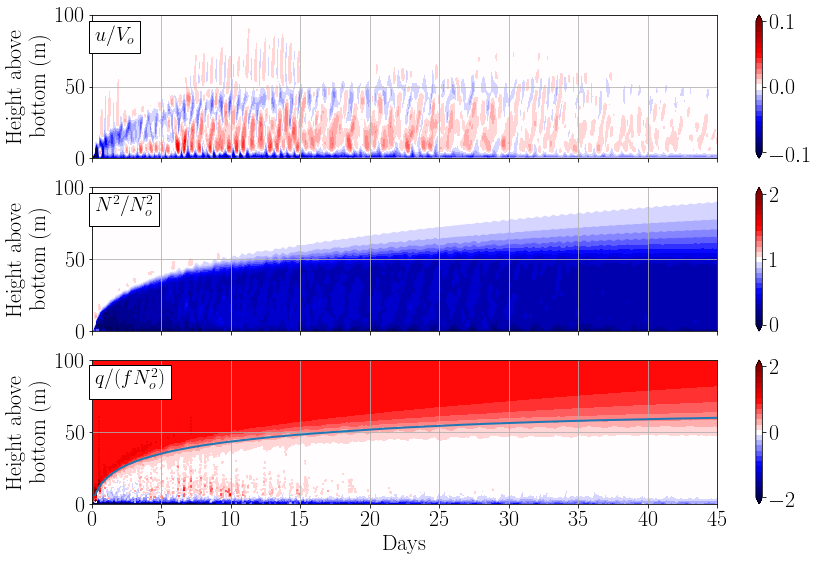

In [431]:
cmin=0
cmax = 2
cminv = 0.03
loff = 20
fig, ax=plt.subplots(3,1, sharex=True, figsize=(14,9))
yl = (zm[0],zm[0]+125)
yl = (z[0], z[0]+100)
#ax[0].plot(time/86400, bflux)
#ax[0].grid()
#plt.colorbar(ax=ax[0])
cminv = -0.1
cmaxv = 0.1
ix = ax[0].contourf(time/86400, z, np.transpose(um[:,:])/0.1,np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[0] , ticks=[cminv,0, cmaxv] )
#cb = plt.colorbar( ix, ax=ax[0])

#ax[0].plot(time/86400, bflux)
# ax[0].set_ylabel('$m^2s^{-3}$')
ax[0].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(0.25,yl[-1]-loff, '$u/V_o$', fontsize=20, bbox=bb)
ax[0].grid()
ax[0].set_ylim(yl)

ix = ax[1].contourf(time/86400, z, np.transpose(bz[:,:])/bz[0, 90],np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[1] , ticks=[cmin,1, cmax] )
#cb = plt.colorbar( ix, ax=ax[0])
ax[1].plot(time/86400, zm[0] + H)

#ax[0].set_xlabel('Days')
ax[1].set_ylabel('Height above\n bottom (m)')#ax[1].set_title('$N^2/N^2_o$')
ax[1].set_ylim(yl)
ax[1].grid()
ax[1].text(0.24, yl[-1]-loff, '$N^2/N^2_o$', fontsize=20, bbox=bb)
#ax[0].plot(time/86400, -Hd)
for c in ix.collections:
    c.set_edgecolor("face")
    
cmin = -15e-9
cmax = 15e-9
cmin = -2
cmax = 2
ix = ax[2].contourf(time/86400, z, np.transpose(qm[:,:])/(1e-4*bz[0,10]), np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
plt.colorbar( ix, ax=ax[2] , ticks=[cmin, 0, cmax] )
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Height above\n bottom (m)')
#ax[2].set_title('q')
ax[2].set_ylim(yl)
ax[2].text(0.25, yl[-1]-loff, '$q/(fN^2_o)$', fontsize=20, bbox=bb)

ax[2].plot(time/86400, H, linewidth=2)
# ax[2].plot(time/86400, h, linewidth=2, linestyle='dashed')

#ax[1].plot(time/86400, -H)
#ax[1].plot(time/86400, -hi)
ax[2].grid()
for c in ix.collections:
    c.set_edgecolor("face")
    
# plt.savefig('Overview3_1e-5_0p05.eps', bbox_inches='tight')

## Plot U, B

Text(0.5,0,'Days')

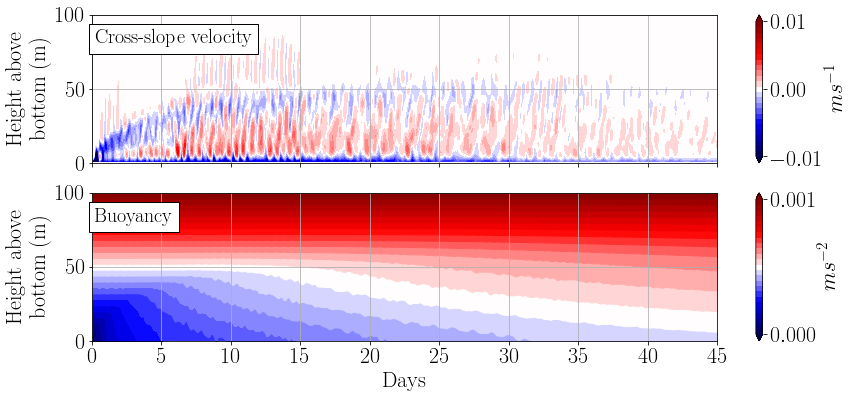

In [432]:
cmin=0
cmax = N**2*np.cos(tht[0,0,0])*100
cmax = 1e-3
cminv = 0.03
loff = 20
fig, ax=plt.subplots(2,1, sharex=True, figsize=(14,6))
yl = (zm[0],zm[0]+125)
yl = (z[0], z[0]+100)
#ax[0].plot(time/86400, bflux)
#ax[0].grid()
#plt.colorbar(ax=ax[0])
cminv = -0.1/10
cmaxv = 0.1/10
ix = ax[0].contourf(time/86400, z, np.transpose(um[:,:]),np.linspace(cminv, cmaxv, 26), vmin=cminv, vmax=cmaxv, cmap='seismic', extend='both')
cb = plt.colorbar( ix, ax=ax[0] , ticks=[cminv,0, cmaxv] )
#cb = plt.colorbar( ix, ax=ax[0])
cb.set_label('$ms^{-1}$')

#ax[0].plot(time/86400, bflux)
# ax[0].set_ylabel('$m^2s^{-3}$')
ax[0].set_ylabel('Height above\n bottom (m)')
bb = dict(boxstyle='Square', fc='w')
ax[0].text(0.25,yl[-1]-loff, 'Cross-slope velocity', fontsize=20, bbox=bb)
ax[0].grid()
ax[0].set_ylim(yl)


# ix = ax[1].contourf(time/86400, z, np.transpose(bz[:,:])/bz[0, 90],np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')
ix = ax[1].contourf(time/86400, z, np.transpose(bm + N**2*np.cos(tht[0,0,0])*z),np.linspace(cmin, cmax, 26), vmin=cmin, vmax=cmax, cmap='seismic', extend='both')

cb = plt.colorbar( ix, ax=ax[1] , ticks=[cmin,1, cmax] )
cb.set_label('$ms^{-2}$')
#cb = plt.colorbar( ix, ax=ax[0])
ax[1].plot(time/86400, zm[0] + H)

#ax[0].set_xlabel('Days')
ax[1].set_ylabel('Height above\n bottom (m)')#ax[1].set_title('$N^2/N^2_o$')
ax[1].set_ylim(yl)
ax[1].grid()
ax[1].text(0.24, yl[-1]-loff, 'Buoyancy', fontsize=20, bbox=bb)
#ax[0].plot(time/86400, -Hd)
for c in ix.collections:
    c.set_edgecolor("face")
ax[1].set_xlabel('Days')

# plt.savefig('Overview2_1e-5_0p02.eps', bbox_inches='tight')

## Make a cross-frontal slice plot

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


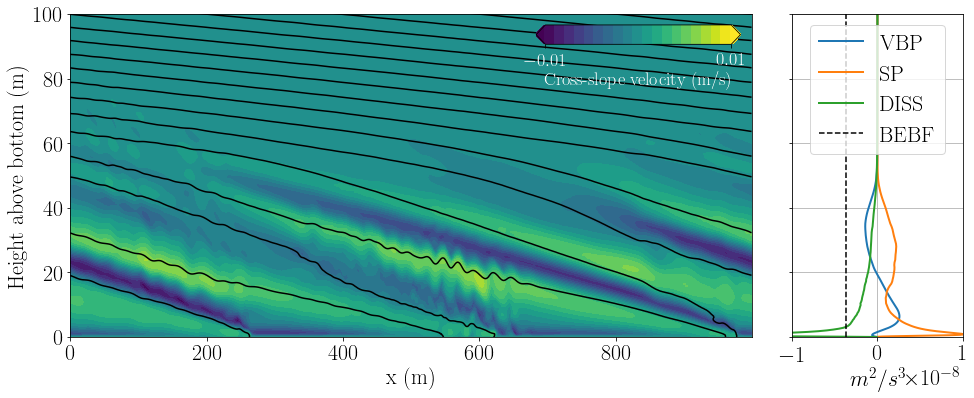

In [433]:
ti = -1;
ti = np.where(time/86400>10)[0][0]
ti = -1
cmin = -0.01
cmax = -cmin

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6), gridspec_kw = {'width_ratios':[4, 1]})
ix = ax[0].contourf(x, zm-zm[0], np.transpose(u[ti,:,:]), np.linspace(cmin, cmax, 20), vmin = cmin, vmax =cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
cbaxes = inset_axes(ax[0], width="30%", height="6%", loc=1, borderpad=0.5, axes_kwargs={'facecolor':'lightgrey'}) 

cb = plt.colorbar(ix, cax=cbaxes, orientation='horizontal', ticks=[cmin, cmax])
cb.set_label('Cross-slope velocity (m/s)', fontsize=18, color='w')
cbaxes.tick_params(labelcolor='w', labelsize=18)
cb.solids.set_edgecolor("face")

ax[0].contour(x, zm-zm[0], np.transpose(bf[ti,:,:]), 50, colors='k')

ax[0].set_xlabel('x (m)')
ax[0].set_ylim((0, 100))

ti = np.where((time/86400>10) & (time/86400<15))[0]

RGSP = gspr[:,0,:]/N**2*np.gradient(bm[:,:], axis=-1)/np.gradient(z)

# PV FLUX PROFILE using <q'w'> ~ f/H Bek
# ax[1].plot(np.mean(np.mean(wq[ti,:,:], axis=1), axis=0), zm-zm[0], label='wq', linewidth=2)

# ax[1].axvline(np.mean(1e-4*Bek[ti]/H[ti]), color='k')
# ax[1].grid()
# ax[1].set_xlabel('$m^2/s^{3}$')
# ax[1].legend(loc=9)
# ax[1].set_xlim((-1e-14, 1e-14))
# ax[0].set_ylabel('Height above bottom (m)')
# plt.tight_layout();

# ENERGY PROFILES
ax[1].plot(np.mean(np.mean(vbfr[ti,:,:], axis=1), axis=0), zm-zm[0], label='VBP', linewidth=2)
ax[1].plot(-np.mean(np.mean(sp[ti,:,:], axis=1), 0), zm-zm[0], label='SP', linewidth=2)
# ax[1].plot(np.mean(RGSP[ti,:], 0), zm-zm[0], label='SP', linewidth=2)

ax[1].plot(np.mean(np.mean(diss[ti,:,:], axis=1), 0), zm-zm[0], label='DISS', linewidth=2)
# ax[1].plot(np.mean(np.mean(vbfr[ti,:,:,] - sp[ti,:,:], axis=1), 0), zm-zm[0], label='SP', linewidth=2)
# ax[1].plot(np.mean(np.mean(vbfr[ti,:,:,], axis=1)+RGSP[ti,:], 0), zm-zm[0], label='SP', linewidth=2)

ax[1].axvline(np.mean(Beka[ti]), color='k', linestyle='dashed', label='BEBF')
# ax[1].axvline(np.mean(Bek[ti]/Ri[ti]), color='k', linestyle='dashed')
ax[1].grid()
ax[1].set_xlabel('$m^2/s^{3}$ ')
ax[1].legend(loc=9)
ax[1].set_xlim(-1e-8, 1e-8)
ax[0].set_ylabel('Height above bottom (m)')
plt.tight_layout();

# plt.savefig('Slice_1e-5_0p02.eps', bbox_inches='tight')

## ENERGY BUDGET

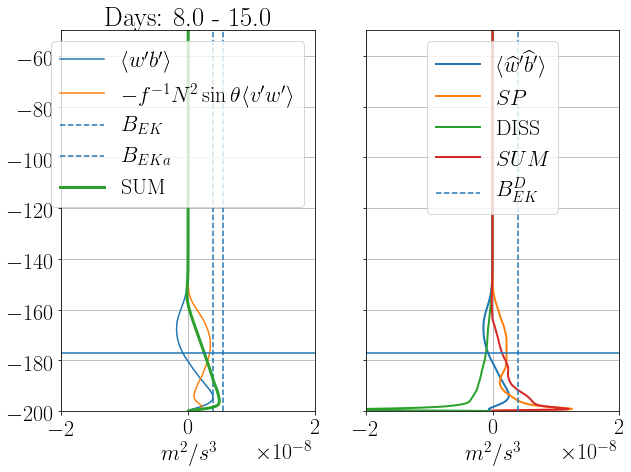

In [434]:
#%% Pseudo-GSP Profile Only
yl = (-200, -50)
xl = (-0.8e-8, 0.8e-8)
xl2 = (-2e-8, 2e-8)
#yl = (-150, 1)

ti = np.where((time/86400>8) & (time/86400<15))[0]
fix, ax = plt.subplots(1,2, sharey=True,figsize=(10, 7))

#BUOYANCY FLUX TERMS
ax[0].set_title('Days: %1.1f - %1.1f' %( time[ti[0]]/86400 , time[ti[-1]]/86400))


ax[0].plot(np.mean(np.mean(vbfrot[ti,:,:], axis=1), axis=0), zm, label='$\langle w^\prime b^\prime\\rangle$')
#plt.plot(-np.mean(gsp[ti,0,:], 0), zm, label='$GSP$')
#ax[0].plot(-np.mean(np.mean(gsp[ti,:,:], axis=1), 0), zm, label='$GSP$')
#ax[0].plot(-np.mean(np.mean(lsp[ti,:,:], axis=1), 0), zm, label='$LSP$')
ax[0].plot(-np.mean(np.mean(gspr[ti,:,:], axis=1), 0), zm, label='$-f^{-1}N^2\sin\\theta\langle v^\prime w^\prime\\rangle $')
#ax[0].plot(-np.mean(np.mean(gspr[ti,:,:]/(1+N**2/1e-8*np.sin(tht[0,0,0])**2), axis=1), 0), zm, label='$-f^{-1}N^2\sin\\theta\langle v^\prime w^\prime\\rangle $')
BGSP = gspr/(1+N**2/1e-8*np.sin(tht[0,0,0])**2)
#ax[0].plot(-np.mean(np.mean(hbfr[ti,:,:], axis=1), 0), zm, label='$HBf$')
ax[0].axvline(-np.mean(Bek[ti]), linestyle='--', label='$B_{EK}$')
ax[0].axvline(-np.mean(Beka[ti]), linestyle='--', label='$B_{EKa}$')

#vspt = vspu+vspv 
#plt.plot(-np.mean(vsp[ti,0,:]-gsp[ti,0,:], 0), zm, label='$ASP$')
##plt.plot(-np.mean(np.mean(vsp[ti,:,:], axis=1), 0), zm, label='$VSP$')
#ax[0].plot(np.mean(np.mean(diss[ti,:,:], axis=1), 0), zm, label='DISS')
#ax[1].plot(np.mean(vbfr[ti,0,:]-gsp[ti,0,:]-lsp[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)
ax[0].plot(np.mean(vbfrot[ti,0,:]-gspr[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)
# ax[0].plot(np.mean(vbfrot[ti,0,:]-BGSP[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)

ax[0].axhline(np.nanmean(h[ti]) + zm[0])

#ax[1].plot(np.mean(vbfr[ti,0,:]-sp[ti,0,:]+0*diss[ti,0,:],0), zm, label = 'SUM', linewidth=3)

#plt.plot(np.mean(vbfr[ti,0,:]-vsp[ti,0,:]-lsp[ti,0,:]+diss[ti,0,:],0), zm, label = 'SUM')
#plt.axhline(-100+np.mean(h[ti]))
#plt.plot(np.mean(vbfr[ti,0,:]-vsp[ti,0,:]-lsp[ti,0,:]+diss[ti,0,:],0), zm, label = 'SUM')

#plt.plot(-100*np.mean(EKEt[ti,:], 0), zm, label='EKE$_t$', linestyle='--')

#ax[1].axvline(-np.mean(BekD[ti]), linestyle='--', label='$B_{EK}^D$')
ax[0].set_xlim(xl2)
ax[0].set_ylim(yl)
ax[0].grid()
ax[0].set_xlabel('$m^2/s^{3}$')
ax[0].legend()

test = gspr[:,0,:]/N**2*np.gradient(bm[:,:], axis=-1)/np.gradient(z)
# ENERGETICS
ax[1].plot(np.mean(np.mean(vbfr[ti,:,:], axis=1), axis=0), zm, label='$\langle \widehat{w}^\prime \widehat{b}^\prime\\rangle$', linewidth=2)

ax[1].plot(-np.mean(np.mean(sp[ti,:,:], axis=1), 0), zm, label='$SP$', linewidth=2)
ax[1].plot(np.mean(np.mean(diss[ti,:,:], axis=1), 0), zm, label='DISS', linewidth=2)
ax[1].plot(np.mean(np.mean(-sp[ti,:,:] +vbfr[ti,:,:], axis=1), 0), zm, label='$SUM$', linewidth=2)
ax[1].axhline(np.nanmean(h[ti]) + zm[0])

ax[1].axvline(-np.mean(Beka[ti]), linestyle='--', label='$B_{EK}^D$')
ax[1].set_xlim(xl2)
ax[1].set_ylim(yl)
ax[1].grid()
ax[1].set_xlabel('$m^2/s^{3}$')
ax[1].legend(loc=9)

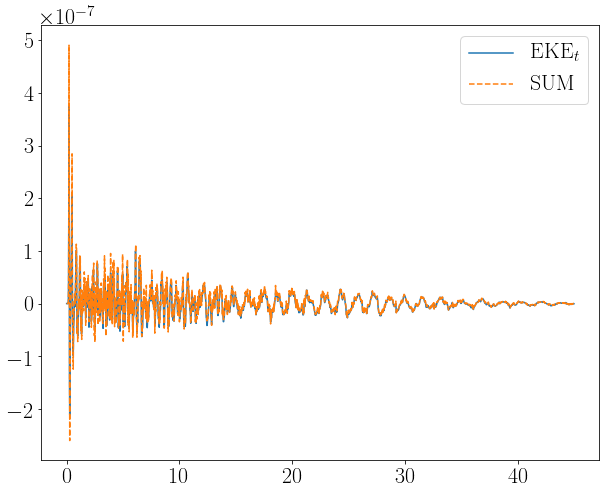

In [435]:
# Sanity check to confirm EKE budget is closed
#%% Plot the depth integrated energy budget (constant depth range)
zl = range(0, zm.size)
zl = np.where((zm>zm[0]+0) & (zm<zm[0]+200))[0]

zd = zm[zl[-1]] - zm[zl[0]]

plt.figure(figsize=(10,8))
plt.plot(time/86400, integrate.trapz(EKEt[:,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE
plt.plot(time/86400, integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl], x=zm[zl], axis=-1), linestyle='dashed', label='SUM')

plt.legend()

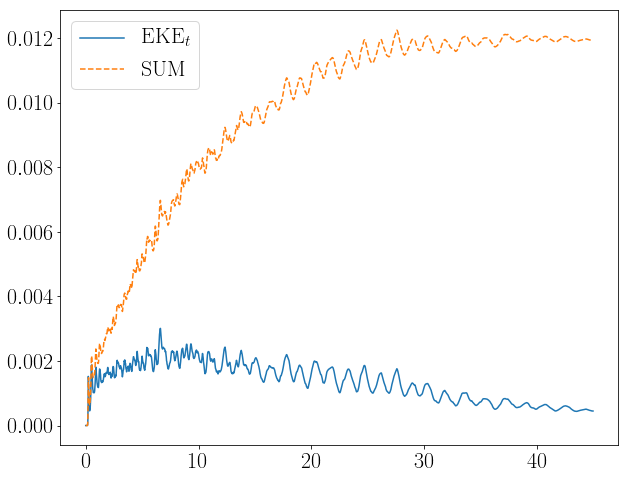

In [436]:
# Sanity check to confirm EKE budget is closed CUMULATIVE
#%% Plot the depth integrated energy budget (constant depth range)
zl = range(0, zm.size)
zl = np.where((zm>zm[0]+0) & (zm<zm[0]+200))[0]

zd = zm[zl[-1]] - zm[zl[0]]

plt.figure(figsize=(10,8))
plt.plot(time/86400, integrate.trapz(EKE[:,0,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE
plt.plot(time/86400, integrate.cumtrapz(integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl], x=zm[zl], axis=-1), x=time, initial=0), linestyle='dashed', label='SUM')

plt.legend()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


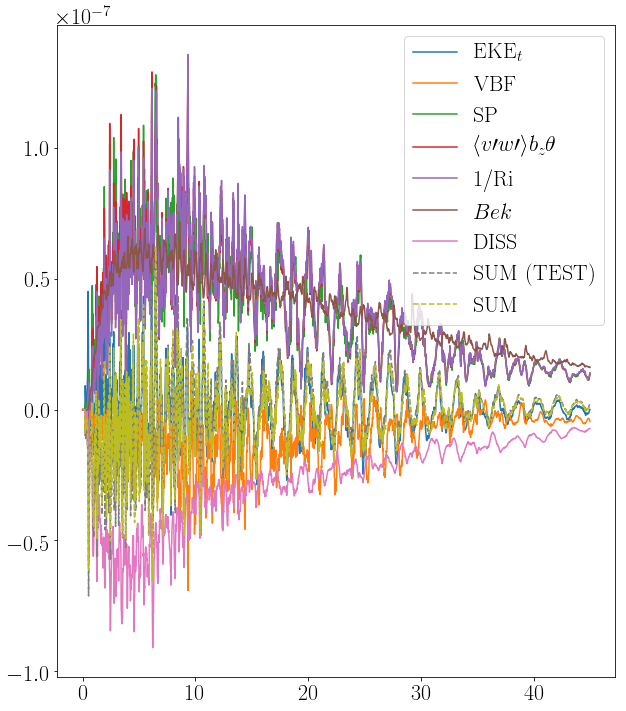

In [437]:
#%% Plot the depth integrated energy budget (constant depth range)
zl = np.where((zm>zm[0]+10) & (zm<zm[0]+200))[0]
zd = zm[zl[-1]] - zm[zl[0]]
Bekfull = np.zeros((EKEt.shape))
Bekfull[:,:] = -Bek[:,np.newaxis]/Ri[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )
Bekfull[Bekfull> 0 ] = 0

Bekfull[:,:] = -Bek[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )/(1+N**2*np.tan(tht[0,0,0])**2/1e-8)
Bekfull[Bekfull> 0 ] = 0


plt.figure(figsize=(10,12))
plt.plot(time/86400, integrate.trapz(EKEt[:,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE

plt.plot(time/86400, integrate.trapz(vbfr[:,0, zl],x=zm[zl], axis=-1 ), label='VBF') # True vertical buoyancy flux
plt.plot(time/86400, -integrate.trapz(sp[:,0,zl], x=zm[zl], axis=-1), label = 'SP') # Total shear production

RGSP = gspr[:,0,:]/N**2*np.gradient(bm[:,:], axis=-1)/np.gradient(z)
plt.plot(time/86400, integrate.trapz(RGSP[:,zl], x=zm[zl], axis=-1), 
         label = '$\langle v\prime w\prime \\rangle b_z\\theta$') # Replace the shear production with the RGSP
redgsp = -gspr[:,0,:]*1/(RiB[:,np.newaxis])
redgsp = -gspr[:,0,:]*1/(1+N**2*np.sin(tht[0,0,0])**2/1e-8)

plt.plot(time/86400, integrate.trapz(redgsp[:,zl], x=zm[zl], axis=-1), label = '1/Ri') # Compare with cross-slope mean
#deltav = va[:,zl[-1]] - va[:,zl[0]]
#test = -gspr[:,0,:]*(1 - (deltav[:,np.newaxis]*np.sin(tht[0,0,0])/(1e-4*zd)))
#plt.plot(time/86400, integrate.trapz(test[:,zl], x=zm[zl], axis=-1), label = '$test$')

plt.plot(time/86400, -integrate.trapz(Bekfull[:,zl], x=zm[zl], axis=-1), label = '$Bek$') # Compare with expectation from B_ek

plt.plot(time/86400, integrate.trapz(diss[:,0,zl], x=zm[zl], axis=-1), label = 'DISS')
plt.plot(time/86400, integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl] + redgsp[:,zl], x=zm[zl], axis=-1), linestyle='dashed', label='SUM (TEST)')
plt.plot(time/86400, integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl], x=zm[zl], axis=-1), linestyle='dashed', label='SUM')

plt.legend()
#plt.ylim((-1e-6, 1e-6))

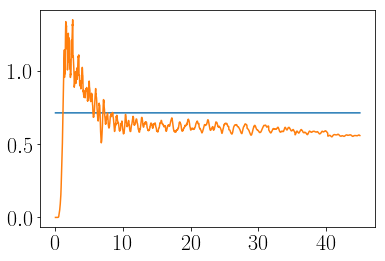

In [438]:
ST = N**2*np.sin(tht[0,0,0])**2/1e-8
plt.plot(time/86400, RiB*0+1/(1+ST))
plt.plot(time/86400, 1/RiB)
# plt.plot(time/86400,1/(1+S))

(-199.99623505652022, -99.99623505652022)

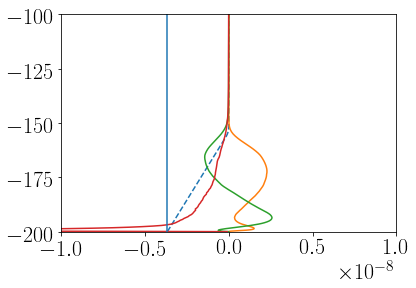

In [439]:
# Look at an example vertical profile, averaged over a timerange
ti = np.where((time/86400>10) & (time/86400<15))[0]

# plt.plot(np.mean(-Bekfull[ti,:], axis=0), zm, linestyle='dashed')
plt.plot(np.mean(Bekfull[ti,:], axis=0), zm, linestyle='dashed')

#plt.plot(np.mean(gspr[ti,0,:]*1/(RiB[ti,np.newaxis]), axis=0), zm)
plt.plot(np.mean(RGSP[ti,:], axis=0), zm)
AGSP = -np.mean(sp, axis=1) - RGSP
esi = np.mean(diss, axis=1) - AGSP
# plt.plot(np.mean(AGSP[ti,:], axis=0), zm)
# plt.plot(np.mean(-sp[ti,0,:], axis=0), zm)
plt.plot(np.mean(vbfr[ti,0,:], axis=0), zm)
plt.plot(np.mean(diss[ti,0,:], axis=0), zm)
# plt.plot(np.mean(esi[ti,:], axis=0), zm)

plt.axvline(np.mean(Beka[ti]))
# plt.axvline(np.mean(-Beka[ti]))

# plt.axhline(np.nanmean(h[ti])+zm[0])
# plt.axhline(np.nanmean(H[ti])+zm[0])

plt.xlim((-1e-8, 1e-8))
plt.ylim((zm[0], zm[0] + 100))

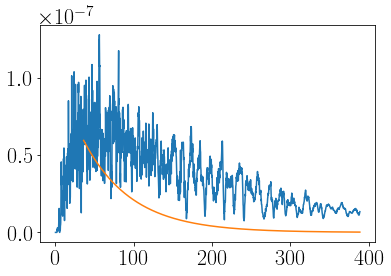

In [440]:
# Look at Buoyancy arrest of shear production
SPI = -integrate.trapz(sp[:,0,zl], x=zm[zl], axis=-1)
plt.plot(time*1e-4, SPI, label = 'SP')

ind = 200
plt.plot(time[ind:]*1e-4,SPI[ind]*exp(-(time[ind:]-time[ind])/tscaleBL))
# plt.plot(time[ind:]*1e-4, -Bek[ind:]*H[ind:]/2/(1+S))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


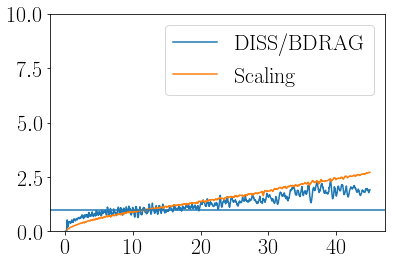

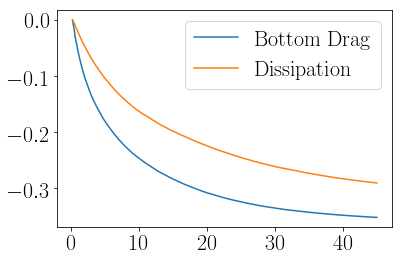

In [441]:
#Ratio of dissipation to bottom drag
cd = 1.8e-3
S = N**2/1e-8*np.tan(tht[0,0,0])**2
# ub = np.abs(np.sqrt(um[:,zind]**2 + (0.1+vm[:,zind])**2))
ubt = np.sqrt(ub**2 + vb**2)
ubt = np.sqrt(np.sqrt(taux**2 + tauy**2)/(3e-3*1030))
zl = np.where((zm>-200) & (zm<zm[0]+200))[0]

dissvar = diss[:,0,:] + 0*vbfr[:,0,:]
# ub = np.sqrt(np.sqrt(taux**2 + tauy**2)/(1035*2.5e-3))
# bdrag = -1030*cd*np.abs(np.sqrt(np.mean(u[:,:,zind]**2 + (0.1+v[:,:,zind])**2, axis=1)))*(vm[:,zind]+0.1)
bdrag = -1030*cd*ubt**3/1030
bdrag = (ub*taux + vb*tauy)/1035
plt.plot(time/86400, integrate.trapz(dissvar[:,zl], x=zm[zl], axis=-1)/bdrag, label = 'DISS/BDRAG')
# plt.plot(time*1e-4, bdrag)
# plt.plot(time*1e-4, tauy)
# plt.plot(time*1e-4, integrate.trapz(diss[:,0,:], x=zm[:], axis=-1)/Bek/((1+S)*2), label = 'DISS')
plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt), label='Scaling')
# plt.plot(time/86400, Bek*H/((1+S)*2)/bdrag, label='DissScale/BDRAG')
plt.ylim(0, 10)
plt.axhline(1)
plt.legend()
# Cumulative

startind = 12
plt.figure()
plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Bottom Drag')
Bekt = Bek
Bekt[~np.isfinite(Bekt)] = 0
Ht = H
Ht[~np.isfinite(H)] = 0
#plt.plot(time[startind:]/86400, integrate.cumtrapz(Bekt[startind:]*Ht[startind:]/(2*(1+S)), x=time[startind:], initial=0), linestyle='dashed')
plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(dissvar[startind:,zl], x=zm[zl], axis=-1), x=time[startind:], initial=0), label='Dissipation')
plt.legend()

## SPECTRAL DOMAIN


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


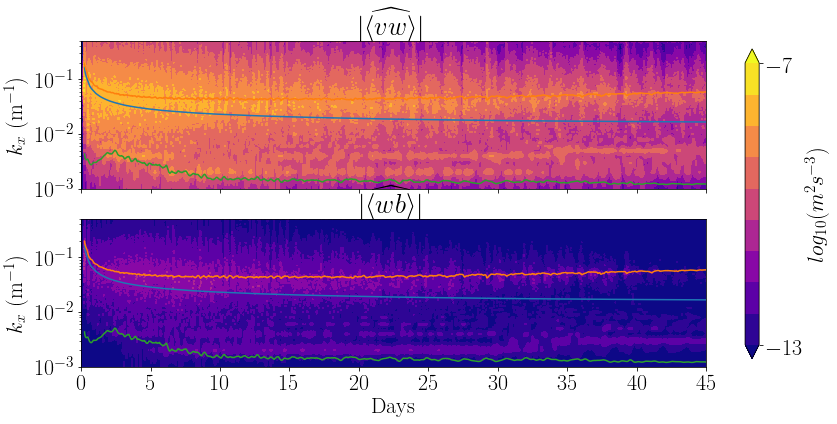

In [442]:
#%% v'w' and w'b'
cmin = -5e-12
cmax = -cmin
cmin = -13
cmax = -7

zl = where((zm>zm[0]+0) & (zm<zm[0]+25) )[0]
IsoSlope = np.arctan2(N**2*tht[0,0,0],(integrate.trapz(bz[:,zl], x=z[zl], axis=-1)/(z[zl[-1]] - z[zl[0]])))
# IsoSlope = np.arctan2((integrate.trapz(bz[:,zl], x=z[zl], axis=-1)/(z[zl[-1]] - z[zl[0]])), - N**2*np.tan(tht[0,0,0]))
# IsoSlope = np.pi/2 - np.tan(tht[0,0,0])/(N**2*np.tan(tht[0,0,0])**2/1e-8)
LScale = np.abs(H/IsoSlope)
fig, ax = plt.subplots(2,1,sharex=True, figsize=(14,6))
ix = ax[0].contourf(time/86400, kx, np.log10(np.abs(np.transpose(integrate.trapz(np.real(kx[np.newaxis,:,np.newaxis]*wvs[:,:,zl]),x=z[zl], axis=-1))/(zm[zl[-1]]-zm[zl[0]]))), 
  np.linspace(cmin, cmax, 10), cmap = 'plasma', vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[0].set_yscale('log')
ax[0].set_ylim((kx[1], kx[-1]))
ax[0].set_ylabel('$k_x$ (m$^{-1}$)')
ax[0].set_title('$|\widehat{\langle v''w''\\rangle}|$')
ax[0].plot(time/86400, 1/H)
ax[0].plot(time/86400, 1/h)
ax[0].plot(time/86400, 1/LScale)

ix = ax[1].contourf(time/86400, kx, np.log10(np.abs(np.transpose(integrate.trapz(np.real(kx[np.newaxis,:,np.newaxis]*wbs[:,:,zl]), x=z[zl],axis=-1))/(zm[zl[-1]] - zm[zl[0]]))), 
  np.linspace(cmin, cmax, 10), cmap = 'plasma', vmin=cmin, vmax=cmax, extend='both')
for c in ix.collections:
    c.set_edgecolor('face')
ax[1].set_yscale('log')
ax[1].set_ylim((kx[1], kx[-1]))
ax[1].set_xlabel('Days')
ax[1].set_ylabel('$k_x$ (m$^{-1}$)')
ax[1].set_title('$|\widehat{\langle w''b''\\rangle}|$')
ax[1].plot(time/86400, 1/H)
ax[1].plot(time/86400, 1/h)
ax[1].plot(time/86400, 1/LScale)

cb = fig.colorbar(ix, ax=ax.ravel().tolist(), shrink=0.95)
cb.set_ticks([cmin, cmax])
cb.set_label('$log_{10}(m^2s^{-3})$')

## EXTRAS

In [443]:
DISSB = f['tasks']['DISSBPRIME']
DISSBPARTIAL = -f['tasks']['DISSBPARTIAL']/N**2

# Eddy buoyancy budget terms
bp = b - bm[:,np.newaxis,:]
bpx = np.gradient(bp, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
bpz = np.gradient(bp, axis=-1)/np.gradient(z)
MIX = -1e-4/N**2*np.mean(bpx**2 + bpz**2, axis=1)

TypeError: bad operand type for unary -: 'Dataset'

In [ ]:
np.abs(LScale)

In [ ]:
plt.plot(integrate.cumtrapz(integrate.trapz(DISSB[:,0,:], x=z, axis=-1), x=time))
plt.plot(integrate.cumtrapz(integrate.trapz(DISSBPARTIAL[:,0,:], x=z, axis=-1), x=time))

plt.plot(integrate.cumtrapz(integrate.trapz(MIX[:,:], x=z, axis=-1), x=time))

In [ ]:
plt.plot(testr*1e-8/np.sin(tht[0,0,0])/N**2)

In [ ]:
plt.plot(time/86400, 1/Ri)
plt.plot(time/86400, 1/RiB)
plt.plot(time/86400, 1-alpha/RiB)
plt.plot(time/86400, (-1 + 0.1*np.sin(tht[0,0,0])/(1e-4*H)))
#plt.plot(time/86400,N**2*tht[0,0,0]*H/(1e-4*0.1))
#plt.ylim((0, 1))

In [ ]:
plt.plot(time/86400, Ri, label='$\zeta/f$')
plt.legend()
plt.ylim(0, 1)

In [ ]:
gspr.shape

In [ ]:
RiB

In [ ]:
plt.plot(np.mean(v[-1,:,:], axis=0), zm)
plt.axvline(0.1/100)
plt.axvline(np.mean(vz[-1,:,:]), color='r')
plt.axhline(zm[0]+H[-1])

In [ ]:
# Ruan bottom stress formulation (with Brink and Lentz adjustment)

#tb = 1030*1e-3*(0.1 - 2/(1+np.sqrt(1+4*Ri*N**2/1e-8*tht[0,0,0]**2))*tht[0,0,0]*N**2*H/1e-4)**2
tb = 1030*1e-3*(0.1 - 1.5/(1+np.sqrt(1+4*Ri*N**2/1e-8*tht[0,0,0]**2))*tht[0,0,0]*N**2*H/1e-4)**2

tscale = 1/((N**2*tht[0,0,0]**2/1e-8)**2*1e-4*np.cos(tht[0,0,0]))
plt.figure(figsize=(10,10))
plt.plot(time/86400, tauy)
plt.plot(time/86400, -tb)
plt.plot(time/86400, -1030*1e-3*0.1**2*((time/tscale)**(-1/2)))

In [ ]:
1e-5*np.tanh(0.0225)**2/1e-8

In [ ]:
(14**3*1e-4/(N**2*tht[0,0,0])*tauy[-1]**2/(1030**2 * 0.1**3*H[-1]))**(1/4)